In [25]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy.stats
import itertools
from matplotlib.ticker import FormatStrFormatter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'
optimization_name = 'min'
N_iters = 26
_, cre_tiles = utils.set_tile_range(196608, 5000)
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f"{utils.make_dir(f'{pdf_base_dir}/higher_order_test/')}{optimization_name}/")
summary_csv_dir = f'../results/summary_csvs/enformer/greedy_search/'

# Heatmaps of CRE locations

In [3]:
location_maps = pd.read_csv(f"{summary_csv_dir}/{optimization_name}_locations.csv")

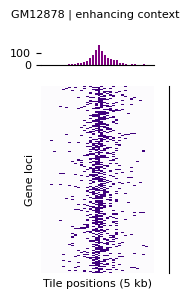

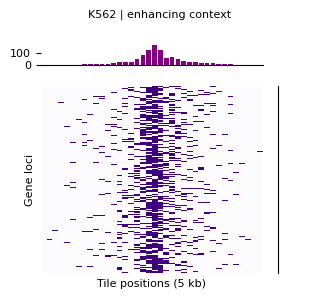

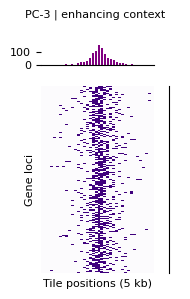

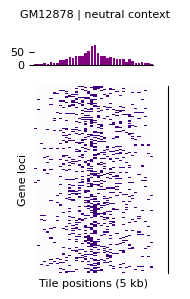

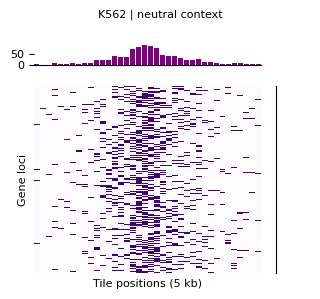

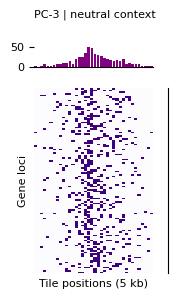

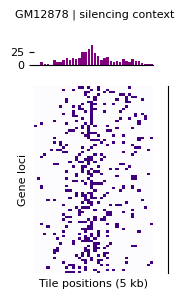

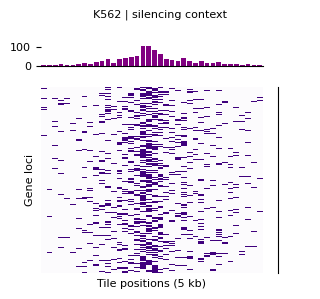

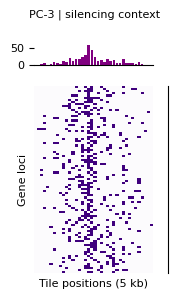

In [6]:
fontsize = 8
for (context, cell_line), context_maps in location_maps.groupby(['context', 'cell_line']):
    
    v = context_maps['tile_selected'].values.reshape((context_maps.shape[0]//38, 38))
    df = pd.DataFrame(v)
    H, D = df.shape
    df = df.reset_index(names='sequence').melt(id_vars='sequence', var_name='position', value_name='Selected')
    
    df['position'] = [int(p) for p in df['position']]
    g = sns.jointplot(data=df, x='position', y='sequence', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(data=df['Selected'].to_numpy().reshape(D, H).T.astype('float'), edgecolor="none", 
                linewidth=0, ax=g.ax_joint, cbar=False, cmap='Purples', rasterized=True, yticklabels=False)
    
    # g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['position'])['Selected'].sum().to_numpy(), color='purple')
    
    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    # g.ax_joint.set_yticks(np.arange(0.5, H))
    # g.ax_joint.set_yticklabels(range(H), rotation=0)
    
    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    # g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.setp(g.ax_marg_x.get_yticklabels(), visible=True,  fontsize=fontsize)

    if cell_line == 'K562':
        g.fig.set_size_inches(3.3, 3)
    else:
        g.fig.set_size_inches(2, 3)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    g.fig.suptitle(f'{cell_line} | {context} context', fontsize=fontsize)
    plt.xticks([])
    plt.ylabel('Gene loci', fontsize=fontsize)
    plt.xlabel('Tile positions (5 kb)', fontsize=fontsize)
    plt.tight_layout()
    

    plt.savefig(f'{pdf_dir}/enhancer_distribution_{cell_line}_{context}.pdf')
    plt.show()


# Traces 

In [9]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

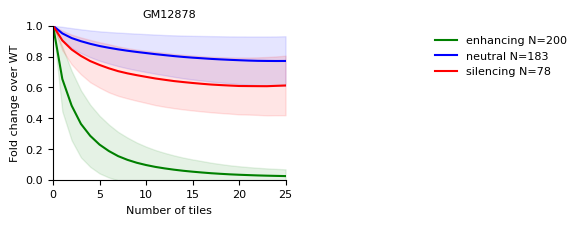

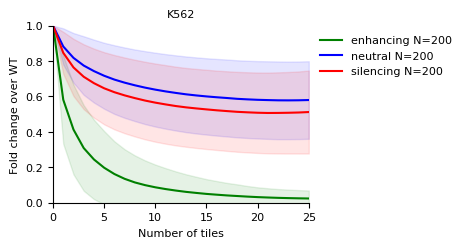

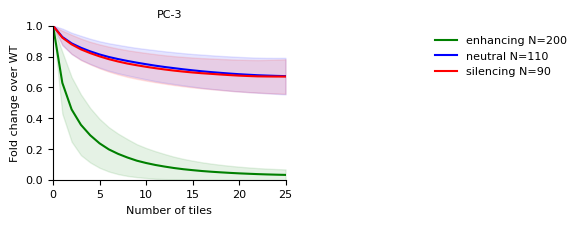

In [17]:
fontsize=8
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for (cell_line), all_context_data in all_traces.groupby('cell_line'):
    if cell_line == 'K562':
        fig, ax = plt.subplots(1, 1, figsize=[3.3,2.3])
    else:
        fig, ax = plt.subplots(1, 1, figsize=[3, 2])

    for context, data in all_context_data.groupby('context'):
        data = data['trace'].values.reshape((data.shape[0]//N_iters, N_iters))
    
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)
        
    plt.legend(frameon=False, bbox_to_anchor=[1.6,1], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0, 25)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.title(cell_line, fontsize=fontsize)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


    plt.xlabel('Number of tiles', fontsize=fontsize)
    plt.ylabel('Fold change over WT', fontsize=fontsize)
    fig.savefig(f'{pdf_dir}/{cell_line}_enhancer_search.pdf', bbox_inches='tight')

In [12]:
pdf_dir

'pdfs/higher_order_test/min/'

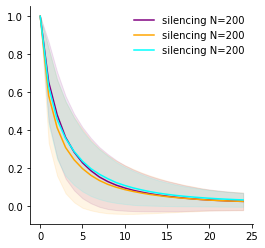

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])
colors = ['purple', 'orange', 'cyan']
for i, (cell_line, df) in enumerate(all_traces.groupby('cell_line')):
    df = df[df['context']=='enhancing']
    data = df['trace'].values.reshape((df.shape[0]//N_iters, N_iters))
  

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    color = color_map[context]
    ax.plot(mean, c=colors[i], alpha=1, label=f'{context} N={data.shape[0]}')
    ax.fill_between(range(N_iters), mean-std, mean+std, alpha=0.1, color=colors[i])

    plt.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig(f"{pdf_dir}/cell_line_comparison.pdf")


# Hypothetical additive model

In [8]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

In [12]:
 titles[p]

'Additivity'

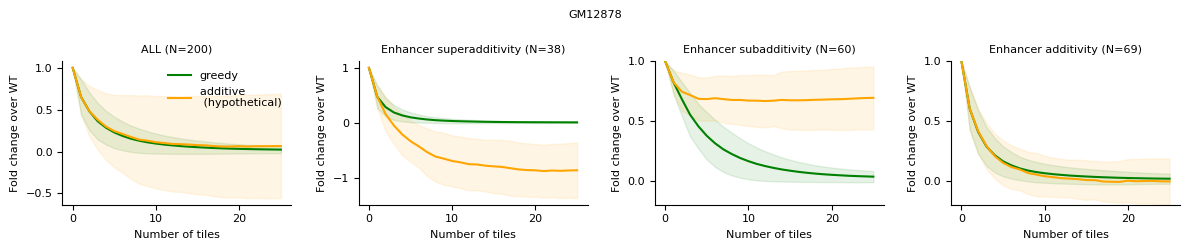

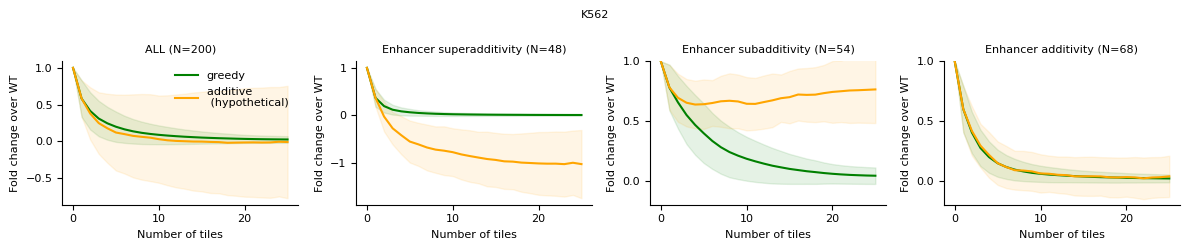

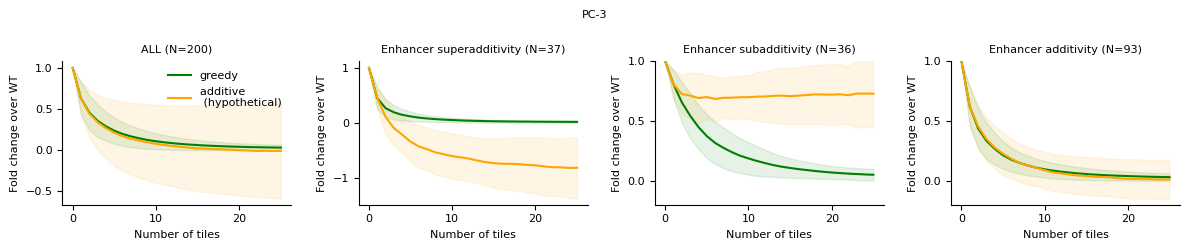

In [24]:

fontsize=8
strata = {}
strata_seq_ids = []
for cell_line, cell_df in all_traces.groupby('cell_line'):
    sign = []
    MSE = []
    cell_enhancing_df = cell_df[cell_df['context']=='enhancing']
    L = cell_enhancing_df.shape[0]
    enhancing_greedy = cell_enhancing_df['trace'].values.reshape(L//N_iters, N_iters)
    enhancing_hyp = cell_enhancing_df['hypothetical_trace'].values.reshape(L//N_iters, N_iters)
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Enhancer superadditivity', 'Enhancer subadditivity', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    seq_ids = cell_enhancing_df['seq_id'].values.reshape(L//N_iters, N_iters)[:,0]
    strata[cell_line] = {'cooperativity': pos_points, 'redundancy': neg_points, 'additivity': zero_points}
    for label_stratum, point_indexes in strata[cell_line].items():
        df_per_stratum = pd.DataFrame(seq_ids[point_indexes])
        df_per_stratum.columns = ['seq_id']
        df_per_stratum['cell_line'] = cell_line
        df_per_stratum['label'] = label_stratum
        strata_seq_ids.append(df_per_stratum)
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[12, 2.5])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} (N={len(points)})', fontsize=fontsize)
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)
            ax.set_xlabel('Number of tiles',fontsize=fontsize)
            ax.set_ylabel('Fold change over WT', fontsize=fontsize)

            if titles[p] in ['Enhancer subadditivity', 'Enhancer additivity']:
                
                ax.set_ylim(-0.2, 1)
                ax.set_yticks([0, 0.5, 1])

            # ax.set_xlim(0, 5)
    axes[0].legend(frameon=False, fontsize=fontsize)
    plt.suptitle(cell_line, fontsize=fontsize)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{cell_line}_greedy_vs_additive.pdf')
strata_seq_ids = pd.concat(strata_seq_ids)

In [29]:
pdf_dir

'pdfs/higher_order_test/min/'

# Example sequence trajectories and sorted effect sizes


In [26]:
k562_df = all_traces[(all_traces['cell_line']=='K562') & (all_traces['context']=='enhancing')]
context_df = pd.read_csv(f'../results/summary_csvs/{model_name}/K562_selected_contexts.csv')
context_df = context_df[context_df['context']=='enhancing']

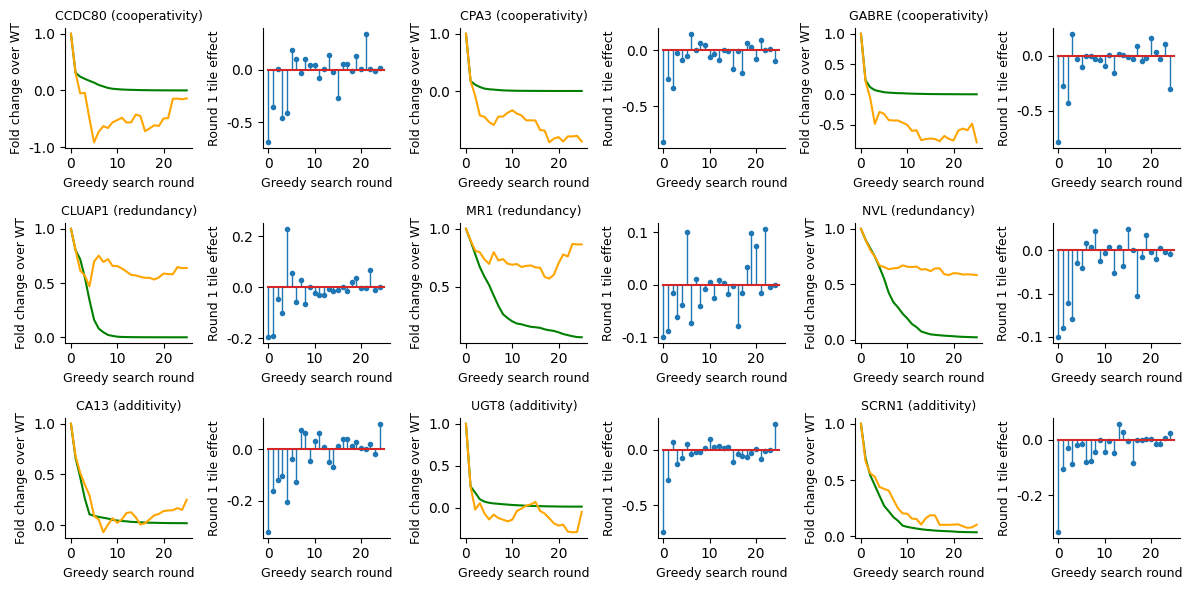

In [29]:
fontsize=9
cell_strata = {'cooperativity': context_df['seq_id'][[126, 71, 111]].values,
              'redundancy': context_df['seq_id'][[53, 183, 15]].values,
              'additivity': context_df['seq_id'][[113, 33, 122]].values}

# row = 0
fig, all_axes = plt.subplots(3, 6, figsize=[12, 6])

for row, (label, seq_ids) in enumerate(cell_strata.items()):
    s = 0
    for seq_id in seq_ids:
        axes_trace = all_axes[row, s]
        axes_lol = all_axes[row, s+1]

        seq_df = k562_df[k562_df['seq_id']==seq_id]
        axes_trace.plot(seq_df['trace'], color='g')
        axes_trace.plot(seq_df['hypothetical_trace'], color='orange')
        axes_trace.set_ylabel('Fold change over WT', fontsize=fontsize)
        axes_trace.set_xlabel('Greedy search round', fontsize=fontsize)
        markerline, stemlines, baseline = axes_lol.stem(seq_df['sorted_effects'])
        plt.setp(stemlines, 'linewidth', 1)
        plt.setp(markerline, markersize=3)


        axes_lol.set_xlabel('Greedy search round', fontsize=fontsize)
        axes_lol.set_ylabel('Round 1 tile effect', fontsize=fontsize)


        # axes[0].set_title(f"{label}-{seq_id}", )
        axes_trace.set_title(f"{seq_id.split('_')[0]} ({label})", fontsize=fontsize)

        for ax in [axes_trace, axes_lol]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        # plt.savefig(f"{pdf_dir}/{label}-{i}")
        # plt.show()
        s += 2
plt.tight_layout()
fig.savefig(f"{pdf_dir}/example_sequences.pdf", bbox_inches='tight')

# 2nd point comparison


In [28]:
second_it_all = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_second_iteration.csv', index_col='Unnamed: 0')

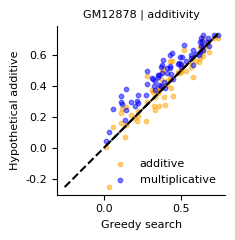

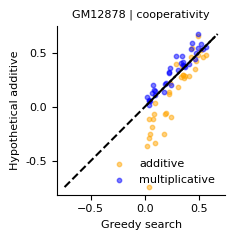

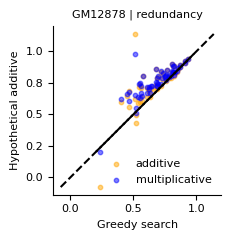

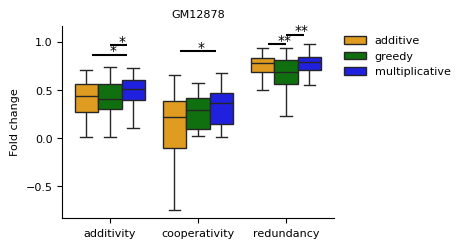

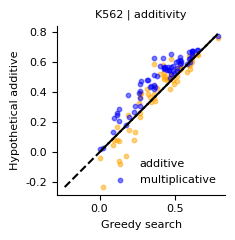

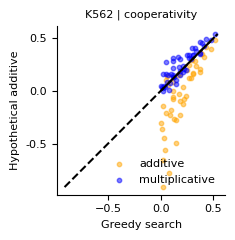

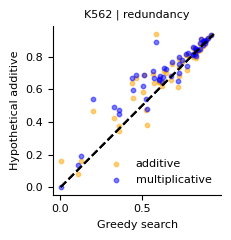

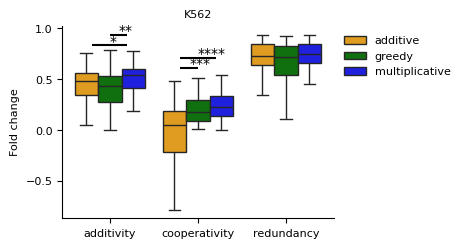

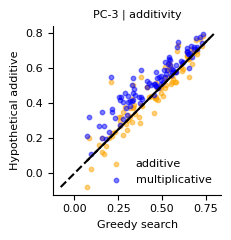

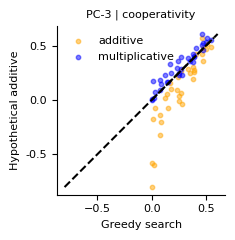

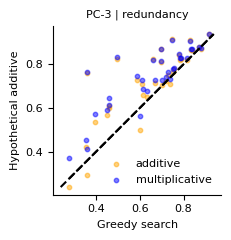

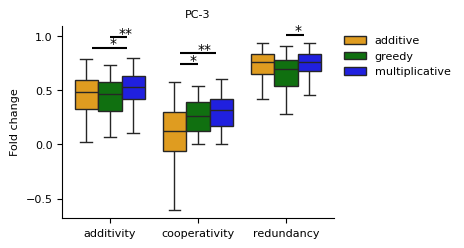

In [39]:
order=['additivity', 'cooperativity', 'redundancy']
hue_order=['additive', 'greedy', 'multiplicative']
context = 'enhancing'


for cell_line, df_cell_line in second_it_all.groupby('cell_line'): 
    
    df_cell_line = df_cell_line[df_cell_line['context']==context] # filter enhancing contexts only
    hypothetical_additive = []
    hypothetical_multiplicative = []
    greedy = []
    seq_ids = []
    for d, (_, data_point) in enumerate(df_cell_line.groupby('seq_id')):
        # WT, p1=prediction when the 1st CRE is shuffled (based on iter1), 
        # p2=prediction when the 2nd CRE is shuffled (based on iter1), 
        # greedy_res = both 1st and 2nd CREs shuffled
        wt, p1, p2, greedy_res = (data_point.iloc[:, 0].values) 
        log_wt, log_p1, log_p2, _ = [np.log(i) for i in data_point.copy().iloc[:,0].values] # same but based on log values
        # record everything
        hypothetical_additive.append((wt + (p1 - wt) + (p2 - wt))/wt) # (WT + effectsize1 + effectsize2) / WT
        hypothetical_multiplicative.append((np.exp(log_wt + (log_p1 - log_wt) + (log_p2 - log_wt)))/wt)
        greedy.append(greedy_res/wt)
        seq_ids.append(data_point['seq_id']['wt'])
    df = pd.DataFrame([hypothetical_additive, hypothetical_multiplicative, greedy, seq_ids]).T
    df.columns = ['additive', 'multiplicative', 'greedy', 'seq_id']
    strata_ids = strata_seq_ids[strata_seq_ids['cell_line']==cell_line]
    df = df.merge(strata_ids, on='seq_id')
    data=df[['additive', 'multiplicative', 'greedy', 'label']].melt(value_vars=['additive', 'multiplicative', 'greedy'], 
                                                               id_vars='label')

    # test box plot elements for significant differences using MannW
    annotations = []
    for s_i, stratum in enumerate(order): # for each group - 'additivity', 'cooperativity', 'redundancy'
        df_stratum = df[df['label']==stratum]  
        y_counter = 0
        for p, pair_index in enumerate(list(itertools.combinations(range(3), 2))): # for each pair

            
            model_type1, model_type2 = hue_order[pair_index[0]], hue_order[pair_index[1]]
            p_sign = utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df_stratum[model_type1].astype(float), 
                                                                                df_stratum[model_type2].astype(float))[1])
            if p_sign!= 'ns': # if significant
                
                # compute hight of box removing outliers
                Q1 = np.quantile(df_stratum['multiplicative'], 0.25)
                Q3 = np.quantile(df_stratum['multiplicative'], 0.75)  
                IQR = Q3 - Q1
                lim = Q3 + 1.5 * IQR  
                annotations.append([s_i-0.2, y_counter, pair_index, p_sign, lim*1.05])
                y_counter += 0.1 # push the bar a bit up to avoid overlaps

        # Plot scatterplots of greedy VS additive/multiplicative
        
        fig, ax = plt.subplots(1, 1, figsize=[2.5, 2.5])
        for p, (x, y) in enumerate([['greedy', 'additive'], ['greedy', 'multiplicative']]):

            ax.set_aspect('equal', adjustable='box')
            ax.scatter(df_stratum[x], df_stratum[y], color=['orange', 'blue'][p], label=y, alpha=0.5, s=10)

            # add X=Y line
            min_point, max_point = df_stratum[[x, y]].min().min(), df_stratum[[x, y]].max().max()
            ax.plot([min_point, max_point], [min_point, max_point], color='k', linestyle='--')
            #ax.set_title(stratum)
            ax.set_xlabel(x)
            ax.set_ylabel('hypothetical')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)
            ax.set_xlabel('Greedy search',fontsize=fontsize)
            ax.set_ylabel('Hypothetical additive', fontsize=fontsize)
            ax.set_title(f"{cell_line} | {stratum}", fontsize=fontsize)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            ax.legend(frameon=False)
        plt.legend(frameon=False, fontsize=fontsize)
        plt.tight_layout()
        fig.savefig(f"{pdf_dir}/2nd_point_comparison_{cell_line}_{stratum}_scatterplot.pdf")
        plt.show()
        
    fig, ax = plt.subplots(1, 1, figsize=[3.5, 2.5])
    sns.boxplot(data=data, x='label', y='value', showfliers=False, 
                   hue='variable', ax=ax, palette=['orange', 'green', 'blue'],
                order=order, hue_order=hue_order)
    ax.set_xlabel('')
    ax.set_ylabel('Fold change over WT', fontsize=fontsize)
    plt.title(f"{cell_line}", fontsize=fontsize)
    for (s_i, y_counter, pair_index, p_sign, y_max) in annotations:
        x1, x2 = s_i+pair_index[0]*0.2, s_i+pair_index[1]*0.2
        y = y_max*0.9+y_counter
        plt.hlines(y, x1, x2, color='k')
        plt.annotate(p_sign, ((x1+x2)/2, y))
    #plt.title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.set_xlabel('',fontsize=fontsize)
    ax.set_ylabel('Fold change', fontsize=fontsize)
    plt.legend(bbox_to_anchor=[1, 1], fontsize=fontsize, frameon=False)
    fig.savefig(f"{pdf_dir}/2nd_point_comparison_{cell_line}_boxplot.pdf", bbox_inches='tight')
    plt.show()


# Hypothetical multiplicative model

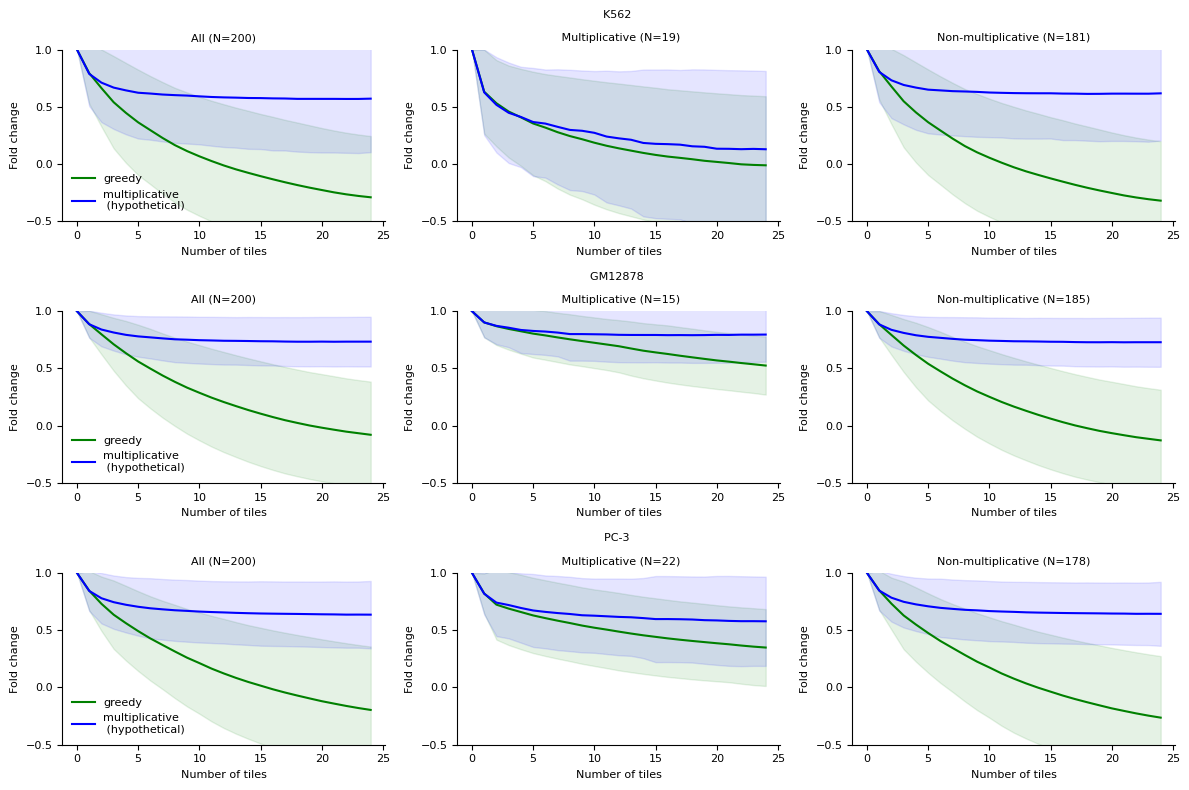

In [149]:

fontsize=8
strata = {}
strata_seq_ids_mult = []
fig, axes = plt.subplots(3, len(titles), figsize=[12, 8])

for c, (cell_line) in enumerate(['K562', 'GM12878', 'PC-3']):
    cell_df = all_traces[all_traces['cell_line']==cell_line]
    sign = []
    MSE = []
    cell_enhancing_df = cell_df[cell_df['context']=='enhancing']
    L = cell_enhancing_df.shape[0]
    enhancing_greedy = cell_enhancing_df['log_trace'].values.reshape(L//N_iters, N_iters)
    enhancing_hyp = cell_enhancing_df['log_hypothetical_trace'].values.reshape(L//N_iters, N_iters)
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'blue']
    # labels = ['cooperative', 'additive']
    titles = ['All', 'Multiplicative', 'Non-multiplicative']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    threshold = 0.04
    bad_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m>threshold]
    good_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<threshold]
    
    seq_ids = cell_enhancing_df['seq_id'].values.reshape(L//N_iters, N_iters)[:,0]
    strata[cell_line] = {'multiplicative': good_points, 'non-multiplicative': bad_points}
    for label_stratum, point_indexes in strata[cell_line].items():
        df_per_stratum = pd.DataFrame(seq_ids[point_indexes])
        df_per_stratum.columns = ['seq_id']
        df_per_stratum['cell_line'] = cell_line
        df_per_stratum['label'] = label_stratum
        strata_seq_ids_mult.append(df_per_stratum)
    all_points = np.arange(len(sign))

    curve_labels = ['greedy', 'multiplicative \n (hypothetical)']
    
    for p, points in enumerate([all_points, good_points, bad_points]):
        ax = axes[c, p]
        if p == 1:
            ax.set_title(f'{cell_line} \n \n {titles[p]} (N={len(points)})', fontsize=fontsize)
        else:
            ax.set_title(f'{titles[p]} (N={len(points)})', fontsize=fontsize)
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)
            ax.set_xlabel('Number of tiles',fontsize=fontsize)
            ax.set_ylabel('Fold change', fontsize=fontsize)
            ax.set_yticks([-0.5, 0, 0.5, 1])

            ax.set_ylim(-0.5, 1)
    axes[c, 0].legend(frameon=False, fontsize=fontsize)
    # plt.suptitle(cell_line, fontsize=fontsize)
    plt.tight_layout()
fig.savefig(f'{pdf_dir}/enhancer_greedy_vs_multiplicative.pdf')
strata_seq_ids_mult = pd.concat(strata_seq_ids_mult)